In [1]:
import pandas as pd
import numpy as np

In [ ]:


df = pd.read_csv("aadhaar_master_dataset.csv")
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M").astype(str)

# Enrolments
df["total_enrolments"] = (
    df["age_0_5"] +
    df["age_5_17"] +
    df["age_18_greater"]
)

df["child_enrolments"] = df["age_0_5"] + df["age_5_17"]

# Updates
df["biometric_updates"] = df["bio_age_5_17"] + df["bio_age_17_"]
df["demographic_updates"] = df["demo_age_5_17"] + df["demo_age_17_"]

df["total_updates"] = df["biometric_updates"] + df["demographic_updates"]

# Overall activity
df["total_activity"] = df["total_enrolments"] + df["total_updates"]


In [2]:
df["CED"] = 1 - (df["child_enrolments"] / (df["total_enrolments"] + 1))


In [3]:
df["UPD"] = 1 - (df["total_updates"] / (df["total_activity"] + 1))


In [4]:
df["child_share"] = df["child_enrolments"] / (df["total_activity"] + 1)
df["adult_share"] = (
    df["age_18_greater"] +
    df["bio_age_17_"] +
    df["demo_age_17_"]
) / (df["total_activity"] + 1)

df["AII"] = df[["child_share", "adult_share"]].max(axis=1)


In [5]:
monthly_activity = (
    df.groupby(["state", "district", "month"])["total_activity"]
      .sum()
      .reset_index()
)

monthly_activity["inactive"] = monthly_activity["total_activity"] == 0

pis = (
    monthly_activity
    .groupby(["state", "district"])["inactive"]
    .mean()
    .reset_index(name="PIS")
)

df = df.merge(pis, on=["state", "district"], how="left")


In [6]:
def normalize(col):
    return (col - col.min()) / (col.max() - col.min() + 1e-9)

df["CED_n"] = normalize(df["CED"])
df["UPD_n"] = normalize(df["UPD"])
df["AII_n"] = normalize(df["AII"])
df["PIS_n"] = normalize(df["PIS"])


In [7]:
df["AIDI_score"] = 100 * (
    0.30 * df["CED_n"] +
    0.25 * df["UPD_n"] +
    0.25 * df["AII_n"] +
    0.20 * df["PIS_n"]
)


In [8]:
df["AIDI_risk"] = pd.cut(
    df["AIDI_score"],
    bins=[0, 30, 60, 100],
    labels=["LOW", "MEDIUM", "HIGH"]
)


In [9]:
df.to_csv("aadhaar_aidi_output.csv", index=False)
print(df[["state", "district", "month", "AIDI_score", "AIDI_risk"]].head())


                         state district    month  AIDI_score AIDI_risk
0  Andaman And Nicobar Islands  Nicobar  2025-03   38.187270    MEDIUM
1  Andaman And Nicobar Islands  Nicobar  2025-04   45.038516    MEDIUM
2  Andaman And Nicobar Islands  Nicobar  2025-05   43.827025    MEDIUM
3  Andaman And Nicobar Islands  Nicobar  2025-06   45.345057    MEDIUM
4  Andaman And Nicobar Islands  Nicobar  2025-07   46.056790    MEDIUM


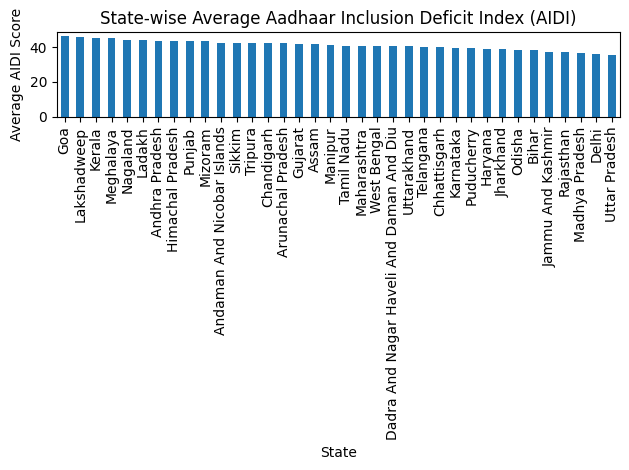

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("aadhaar_aidi_output.csv")

state_avg = (
    df.groupby("state")["AIDI_score"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure()
state_avg.plot(kind="bar")
plt.title("State-wise Average Aadhaar Inclusion Deficit Index (AIDI)")
plt.xlabel("State")
plt.ylabel("Average AIDI Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

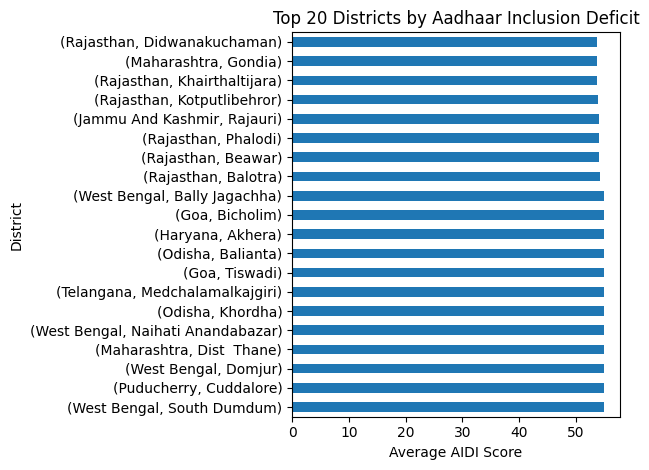

In [3]:
district_avg = (
    df.groupby(["state", "district"])["AIDI_score"]
      .mean()
      .sort_values(ascending=False)
      .head(20)
)

plt.figure()
district_avg.plot(kind="barh")
plt.title("Top 20 Districts by Aadhaar Inclusion Deficit")
plt.xlabel("Average AIDI Score")
plt.ylabel("District")
plt.tight_layout()
plt.show()

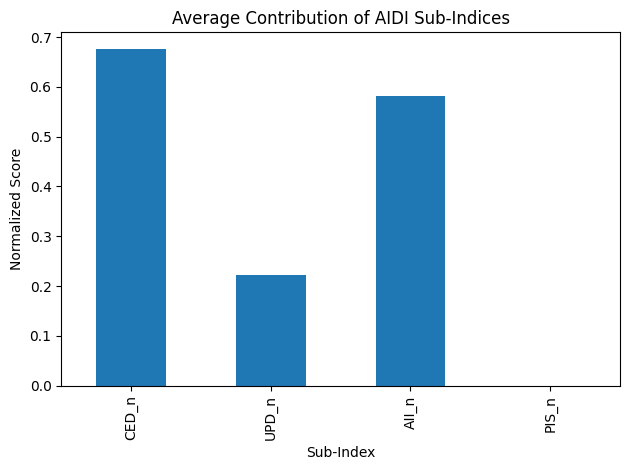

In [4]:
drivers = df[["CED_n", "UPD_n", "AII_n", "PIS_n"]].mean()

plt.figure()
drivers.plot(kind="bar")
plt.title("Average Contribution of AIDI Sub-Indices")
plt.xlabel("Sub-Index")
plt.ylabel("Normalized Score")
plt.tight_layout()
plt.show()

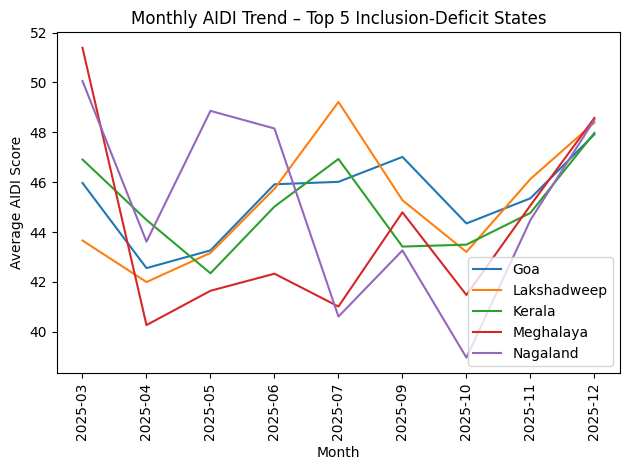

In [5]:
top_states = state_avg.head(5).index

plt.figure()
for state in top_states:
    temp = df[df["state"] == state]
    monthly = temp.groupby("month")["AIDI_score"].mean()
    plt.plot(monthly.index, monthly.values, label=state)

plt.title("Monthly AIDI Trend – Top 5 Inclusion-Deficit States")
plt.xlabel("Month")
plt.ylabel("Average AIDI Score")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("aadhaar_aidi_output.csv")

df["district"] = df["district"].str.title().str.strip()
df["state"] = df["state"].str.title().str.strip()


<>:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
<>:6: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
<>:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
<>:6: SyntaxWarning: "\C" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\C"? A raw string is also an option.
C:\Users\omyad\AppData\Local\Temp\ipykernel_18232\2816135719.py:5: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
  states_gdf = gpd.read_file("States\Admin2.shp")
C:\Users\omyad\AppData\Local\Temp\ipykernel_18232\2816135719.py:6: SyntaxWarning: "\C" is an invalid escape sequence. Such s

In [ ]:
gdf = gpd.read_file("data/india_district.geojson")

print(gdf.columns)



In [ ]:
with open("data/india_district.geojson", "r", encoding="utf-8") as f:
    print(f.read(300))

<Figure size 1200x1200 with 0 Axes>

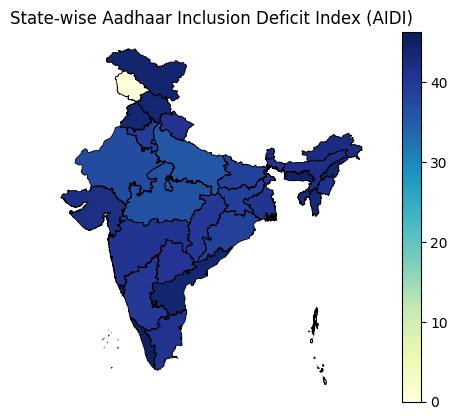

In [ ]:
import json
import geopandas as gpd
from shapely.geometry import shape

with open("data/india_district.geojson", "r", encoding="utf-8") as f:
    data = json.load(f)

records = []
for feature in data["features"]:
    props = feature["properties"]
    geom = shape(feature["geometry"])
    records.append({**props, "geometry": geom})

gdf = gpd.GeoDataFrame(records, crs="EPSG:4326")

print(gdf.columns)

<Figure size 1400x1400 with 0 Axes>

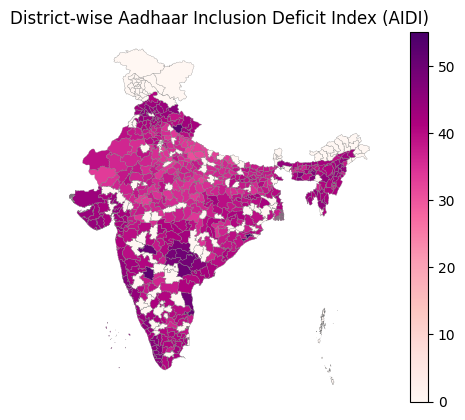

In [ ]:
gdf["NAME_1"] = gdf["NAME_1"].str.title().str.strip()
gdf["NAME_2"] = gdf["NAME_2"].str.title().str.strip()


In [ ]:
import pandas as pd

df = pd.read_csv("result/aadhaar_aidi_output.csv")

df["state"] = df["state"].str.title().str.strip()
df["district"] = df["district"].str.title().str.strip()

In [ ]:
district_fix = {
    "Nicobar": "Nicobar Islands",
    "Bangalore Urban": "Bengaluru Urban"
}

df["district"] = df["district"].replace(district_fix)

In [ ]:
merged_gdf = gdf.merge(
    df,
    left_on=["NAME_2", "NAME_1"],
    right_on=["district", "state"],
    how="inner"
)

In [ ]:
print("Total GeoJSON districts:", len(gdf))
print("Matched districts:", len(merged_gdf))

In [ ]:
latest_month = df["month"].max()
df_latest = df[df["month"] == latest_month]
merged_gdf = gdf.merge(
    df_latest,
    left_on=["NAME_2", "NAME_1"],
    right_on=["district", "state"],
    how="inner"
)
print(len(merged_gdf))

In [ ]:
df_district = (
    df_latest
    .groupby(["state", "district"], as_index=False)
    .agg({
        "AIDI_score": "mean",
        "CED": "mean",
        "UPD": "mean",
        "AII": "mean",
        "total_enrolments": "sum",
        "total_updates": "sum"
    })
)


In [ ]:
merged_gdf = gdf.merge(
    df_district,
    left_on=["NAME_2", "NAME_1"],
    right_on=["district", "state"],
    how="inner"
)


In [ ]:
print("GeoJSON districts:", len(gdf))        # ~666
print("Merged districts:", len(merged_gdf)) # ~600–700 ✅


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14, 16))

merged_gdf.plot(
    column="AIDI_score",          # change if column name differs
    cmap="RdYlGn_r",
    linewidth=0.2,
    ax=ax,
    edgecolor="black",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)

ax.set_title(
    "Aadhaar Inclusion Development Index (AIDI)\nDistrict-Level Analysis",
    fontsize=16
)

ax.axis("off")

plt.show()


In [ ]:
# Aggregate AIDI_score by state (mean or sum, depending on your preference)
state_data = df.groupby("state")["AIDI_score"].mean().reset_index()  # mean gives average AIDI
state_data.rename(columns={"AIDI_score": "AIDI"}, inplace=True)

In [ ]:
import json

with open("data/india_state.geojson") as f:
    india_geojson = json.load(f)

In [ ]:
india_geojson["features"][0]["properties"].keys()

In [ ]:
geo_states = [f["properties"]["NAME_1"] for f in india_geojson["features"]]

print(geo_states)


In [ ]:
aadhaar_states = sorted(df["state"].dropna().unique())
print(aadhaar_states)


In [ ]:
state_name_map = {
    # Andaman
    "Andaman And Nicobar Islands": "Andaman and Nicobar",

    # Dadra / Daman
    "Dadra And Nagar Haveli And Daman And Diu": "Dadra and Nagar Haveli",
    # Note: GeoJSON has Daman and Diu separately

    # Delhi
    "Delhi": "NCT of Delhi",

    # Jammu & Kashmir
    "Jammu And Kashmir": "Jammu and Kashmir"
}
df = df[df["state"] != "Ladakh"]
df["state"] = df["state"].replace(state_name_map)

In [ ]:
state_data = (
    df.groupby("state")["AIDI_score"]
    .mean()
    .reset_index()
    .rename(columns={"AIDI_score": "AIDI"})
)


In [ ]:
geo_states = {f["properties"]["NAME_1"] for f in india_geojson["features"]}
csv_states = set(state_data["state"])

print(csv_states - geo_states)


In [ ]:
fig = px.choropleth(
    state_data,
    geojson=india_geojson,
    featureidkey="properties.NAME_1",
    locations="state",
    color="AIDI",
    color_continuous_scale="RdYlGn_r",
    hover_name="state",
    title="State-wise AIDI Risk Index"
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()
